In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# MICCAI 2023 patient experiment

In [3]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023'

In [13]:
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=bio170034p
#SBATCH --partition=BatComputer
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --noise_ratio {noise_ratio} \\
    --omega {omega} \\
    --polar_input {polar_input} \\
    --savgol_filter {savgol_filter} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --a_loss_weight {a_loss_weight} \\
    --anatomical {anatomical} \\
    --n_iters {n_iters} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{savgol_filter}_{pde_name}'

param_space = ps.ParamSpace(
    data_name='patient',
    xarray_dir='../../../data/NAFLD/v4',
    example_id=['0006', '0020', '0024', '0029', '0043', '0047', '0126', '0135', '0155', '0164', '0172', '0173', '0210', '0213', '0219', '0222', '0234', '0235', '0291', '0344', '0378', '0384', '0395', '0401', '0415', '0457', '0461', '0491', '0492', '0496', '0509', '0510', '0516', '0525', '0564', '0604', '0612', '0615', '0628', '0639', '0648', '0650', '0653', '0655', '0659', '0693', '0704', '0717', '0727', '0734', '0737', '0740', '0747', '0748', '0898', '0900', '0929', '0931', '0932', '0940', '0954', '0964', '0965', '0979', '0989', '0995', '1028', '1033', '1039', '1045', '1075', '1076', '1077', '1083', '1103', '1106', '1108', '1110', '1119', '1121', '1123', '1134', '1144', '1149', '1205', '1207', '1215', '1217', '1230', '1261', '1271', '1296', '1303', '1311', '1329', '1337', '1341', '1343', '1344', '1382', '1395', '1400', '1404', '1417', '1426', '1427', '1433', '1435', '1448', '1453', '1456', '1464', '1671', '1679', '1694', '1699', '1706', '1712', '1714', '1715', '1720', '1722', '1727', '1736', '1748', '1785', '1786', '1790', '1791', '1793', '1795', '1798', '1806', '1807', '1819', '1829', '1839', '1843', '1851', '1853', '1896', '1899', '1903', '1917', '1935', '1940', '1948', '1967', '1979', '1980', '2001', '2007', '2029', '2034', '2046'],
    frequency=40,
    noise_ratio=0.0,
    omega=[30],
    polar_input=1,
    savgol_filter=[0, 1],
    pde_name=['helmholtz', 'hetero'],
    pde_init_weight=1e-18,
    pde_loss_weight=1e-16,
    a_loss_weight=[0],
    anatomical=True,
    n_iters=1,
)

len(param_space)

620

In [76]:
%autoreload

expt_name0 = '2023-2-16_patient_anat' # a_loss_weight
expt_name1 = '2023-2-18_patient_anat' # move queued jobs to GPU-shared
expt_name2 = '2023-2-20_patient_anat2' # expanded a_loss_weight range
expt_name = '2023-2-26_patient_FEM' # just the new FEM baselines

#jobs = ps.submit(template, name, list(param_space), work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

#jobs0 = pd.read_csv(f'{expt_name0}.jobs', index_col=0)
#jobs1 = pd.read_csv(f'{expt_name1}.jobs', index_col=0)
#jobs2 = pd.read_csv(f'{expt_name2}.jobs', index_col=0)
#jobs = pd.concat([jobs0, jobs1, jobs2])

jobs = pd.read_csv(f'{expt_name}.jobs', index_col=0)
jobs

,data_name,xarray_dir,example_id,frequency,noise_ratio,omega,polar_input,savgol_filter,pde_name,pde_init_weight,...,anatomical,n_iters,job_name,job_id,partition,job_state,node_id,runtime,work_dir,array_idx
0,patient,../../../data/NAFLD/v4,6,40,0.0,30,1,0,helmholtz,1.000000e-18,...,True,1,train_patient_0006_0_helmholtz,14691123,BatComputer,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
1,patient,../../../data/NAFLD/v4,6,40,0.0,30,1,0,hetero,1.000000e-18,...,True,1,train_patient_0006_0_hetero,14691124,BatComputer,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
2,patient,../../../data/NAFLD/v4,6,40,0.0,30,1,1,helmholtz,1.000000e-18,...,True,1,train_patient_0006_1_helmholtz,14691125,BatComputer,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
3,patient,../../../data/NAFLD/v4,6,40,0.0,30,1,1,hetero,1.000000e-18,...,True,1,train_patient_0006_1_hetero,14691126,BatComputer,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
4,patient,../../../data/NAFLD/v4,20,40,0.0,30,1,0,helmholtz,1.000000e-18,...,True,1,train_patient_0020_0_helmholtz,14691127,BatComputer,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,patient,../../../data/NAFLD/v4,2034,40,0.0,30,1,1,hetero,1.000000e-18,...,True,1,train_patient_2034_1_hetero,14691738,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
616,patient,../../../data/NAFLD/v4,2046,40,0.0,30,1,0,helmholtz,1.000000e-18,...,True,1,train_patient_2046_0_helmholtz,14691739,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
617,patient,../../../data/NAFLD/v4,2046,40,0.0,30,1,0,hetero,1.000000e-18,...,True,1,train_patient_2046_0_hetero,14691740,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
618,patient,../../../data/NAFLD/v4,2046,40,0.0,30,1,1,helmholtz,1.000000e-18,...,True,1,train_patient_2046_1_helmholtz,14691741,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN


In [143]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs, parse=True)
status[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
14691123,train_patient_0006_0_helmholtz,NaN,NaN,NaN,[546 rows x 4 columns],None
14691124,train_patient_0006_0_hetero,NaN,NaN,NaN,[546 rows x 4 columns],None
14691125,train_patient_0006_1_helmholtz,NaN,NaN,NaN,[546 rows x 4 columns],None
14691126,train_patient_0006_1_hetero,NaN,NaN,NaN,[546 rows x 4 columns],None
14691127,train_patient_0020_0_helmholtz,NaN,NaN,NaN,[546 rows x 4 columns],None
...,...,...,...,...,...,...
14691738,train_patient_2034_1_hetero,NaN,NaN,NaN,[546 rows x 4 columns],None
14691739,train_patient_2046_0_helmholtz,NaN,NaN,NaN,[546 rows x 4 columns],None
14691740,train_patient_2046_0_hetero,NaN,NaN,NaN,[546 rows x 4 columns],None


In [144]:
status['has_error'] = ~status.stderr.isnull()
status['python_error'] = status.stderr.astype(str).str.contains('python: command not found')

status.fillna('DONE').groupby(['job_state', 'has_error', 'python_error'])[['job_name']].count()

,,,job_name
job_state,has_error,python_error,
DONE,False,False,620


In [161]:
pinn_jobs = pd.concat([
    pd.read_csv(f'2023-2-16_patient_anat.jobs', index_col=0),
    pd.read_csv(f'2023-2-18_patient_anat.jobs', index_col=0),
    pd.read_csv(f'2023-2-20_patient_anat2.jobs', index_col=0)
])
fem_jobs = pd.read_csv(f'2023-2-26_patient_FEM.jobs', index_col=0)

param_cols = ['pde_name', 'example_id', 'omega', 'a_loss_weight', 'savgol_filter'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric values

pinn_metrics = ps.metrics(pinn_jobs)
pinn_metrics['savgol_filter'] = 0

pinn_metrics_sg = pinn_metrics.copy()
pinn_metrics_sg['savgol_filter'] = 1

pinn_metrics = pd.concat([pinn_metrics, pinn_metrics_sg])

fem_metrics = ps.metrics(fem_jobs)
fem_metrics.iteration *= 100000

train_patient_0748_30_hetero_1e-04 No objects to concatenate
train_patient_0748_30_hetero_1e-02 No objects to concatenate
train_patient_0748_30_hetero_1e+00 No objects to concatenate
train_patient_0898_30_hetero_0e+00 No objects to concatenate
train_patient_0898_30_hetero_1e-04 No objects to concatenate
train_patient_0898_30_hetero_1e-02 No objects to concatenate
train_patient_0898_30_hetero_1e+00 No objects to concatenate
train_patient_0900_30_hetero_0e+00 No objects to concatenate
train_patient_0900_30_hetero_1e-04 No objects to concatenate
train_patient_0900_30_hetero_1e-02 No objects to concatenate
train_patient_0900_30_hetero_1e+00 No objects to concatenate
train_patient_0929_30_hetero_0e+00 No objects to concatenate
train_patient_0929_30_hetero_1e-04 No objects to concatenate
train_patient_0929_30_hetero_1e-02 No objects to concatenate
train_patient_0929_30_hetero_1e+00 No objects to concatenate
train_patient_0931_30_hetero_0e+00 No objects to concatenate
train_patient_0931_30_he

train_patient_1829_30_hetero_1e-02 No objects to concatenate
train_patient_1829_30_hetero_1e+00 No objects to concatenate
train_patient_1839_30_hetero_0e+00 No objects to concatenate
train_patient_1839_30_hetero_1e-04 No objects to concatenate
train_patient_1839_30_hetero_1e-02 No objects to concatenate
train_patient_1839_30_hetero_1e+00 No objects to concatenate
train_patient_1843_30_hetero_0e+00 No objects to concatenate
train_patient_1843_30_hetero_1e-04 No objects to concatenate
train_patient_1843_30_hetero_1e-02 No objects to concatenate
train_patient_1843_30_hetero_1e+00 No objects to concatenate
train_patient_1851_30_hetero_0e+00 No objects to concatenate
train_patient_1851_30_hetero_1e-04 No objects to concatenate
train_patient_1851_30_hetero_1e-02 No objects to concatenate
train_patient_1851_30_hetero_1e+00 No objects to concatenate
train_patient_1853_30_hetero_0e+00 No objects to concatenate
train_patient_1853_30_hetero_1e-04 No objects to concatenate
train_patient_1853_30_he

train_patient_1215_30_hetero_1e-04 No objects to concatenate
train_patient_1217_30_hetero_1e+00 No objects to concatenate
train_patient_1230_30_hetero_0e+00 No objects to concatenate
train_patient_1230_30_hetero_1e-02 No objects to concatenate
train_patient_1261_30_hetero_0e+00 No objects to concatenate
train_patient_1261_30_hetero_1e-04 No objects to concatenate
train_patient_1261_30_hetero_1e-02 No objects to concatenate
train_patient_1261_30_hetero_1e+00 No objects to concatenate
train_patient_1271_30_hetero_0e+00 No objects to concatenate
train_patient_1271_30_hetero_1e-04 No objects to concatenate
train_patient_1271_30_hetero_1e-02 No objects to concatenate
train_patient_1271_30_hetero_1e+00 No objects to concatenate
train_patient_1296_30_hetero_0e+00 No objects to concatenate
train_patient_1296_30_hetero_1e-04 No objects to concatenate
train_patient_1296_30_hetero_1e-02 No objects to concatenate
train_patient_1296_30_hetero_1e+00 No objects to concatenate
train_patient_1303_30_he

train_patient_0929_30_hetero_1e-03 No objects to concatenate
train_patient_0931_30_hetero_1e+01 No objects to concatenate
train_patient_0954_30_hetero_1e+01 No objects to concatenate
train_patient_0954_30_hetero_1e+02 No objects to concatenate
train_patient_0979_30_hetero_1e+02 No objects to concatenate
train_patient_1028_30_hetero_1e-03 No objects to concatenate
train_patient_1033_30_hetero_1e+01 No objects to concatenate
train_patient_1033_30_hetero_1e+02 No objects to concatenate
train_patient_1039_30_hetero_1e+01 No objects to concatenate
train_patient_1039_30_hetero_1e+02 No objects to concatenate
train_patient_1039_30_hetero_1e-01 No objects to concatenate
train_patient_1039_30_hetero_1e-03 No objects to concatenate
train_patient_1075_30_hetero_1e+01 No objects to concatenate
train_patient_1075_30_hetero_1e-03 No objects to concatenate
train_patient_1076_30_hetero_1e-01 No objects to concatenate
train_patient_1076_30_hetero_1e-03 No objects to concatenate
train_patient_1077_30_he

In [162]:
param_cols = ['pde_name', 'example_id', 'omega', 'a_loss_weight', 'savgol_filter'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric values

def metric_map(tup):
    metric_name, var_name = tup
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

def format_metrics(metrics):
    metrics = metrics[metrics.iteration == 100e3]
    metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
    metrics = metrics.unstack(level=[len(param_cols)])
    metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
    return metrics

def replace_metrics(m1, m2, index1, index2, columns):
    m1 = m1.reset_index().set_index(index2)
    m2 = m2.reset_index().set_index(index2)
    m1[columns] = m2[columns]
    return m1.reset_index().set_index(index1)
    
pinn_metrics = format_metrics(pinn_metrics)
fem_metrics  = format_metrics(fem_metrics)

metrics = replace_metrics(
    pinn_metrics, fem_metrics,
    index1=param_cols + index_cols[1:],
    index2=['pde_name', 'example_id', 'savgol_filter'] + index_cols[1:],
    columns=[c for c in fem_metrics if c.startswith('fem')]
)
metrics

a_pred_MSAV  \
pde_name example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                 
hetero   6          30    0.000         0             all                   all             32530.800049   
                                                                            0.0                      NaN   
                                                                            1.0                      NaN   
                                                      1.0                   all                      NaN   
                                                      2.0                   all                      NaN   
...                                                                                                  ...   
         2034       30    0.001         1             6.0                   all                      NaN   
                                                      7.0                   all                      NaN   
                                                      8.0                   all                      NaN   
                                                      9.0                   all                      NaN   
                                                      10.0                  all                      NaN   

                                                                                             a_pred_MSAE  \
pde_name example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                 
hetero   6          30    0.000         0             all                   all             39580.173965   
                                                                            0.0                      NaN   
                                                                            1.0                      NaN   
                                                      1.0                   all                      NaN   
                                                      2.0                   all                      NaN   
...                                                                                                  ...   
         2034       30    0.001         1             6.0                   all                      NaN   
                                                      7.0                   all                      NaN   
                                                      8.0                   all                      NaN   
                                                      9.0                   all                      NaN   
                                                      10.0                  all                      NaN   

                                                                                             a_true_MSAV  \
pde_name example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                 
hetero   6          30    0.000         0             all                   all             19750.975778   
                                                                            0.0                      NaN   
                                                                            1.0                      NaN   
                                                      1.0                   all                      NaN   
                                                      2.0                   all                      NaN   
...                                                                                                  ...   
         2034       30    0.001         1             6.0                   all                      NaN   
                                                      7.0                   all                      NaN   
                                                      8.0                   all                      NaN   
                                                      9.0                   all                

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


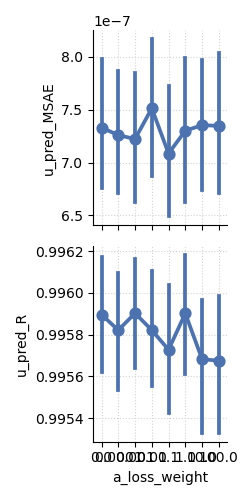

In [163]:
m = pinn_metrics.reset_index()

fig = ps.plot(
    m[m.spatial_region == 'all'],
    x=['a_loss_weight'],
    y=['u_pred_MSAE', 'u_pred_R'],
    height=2.5,
    width=2.5,
    legend=False,
    tight=True
)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


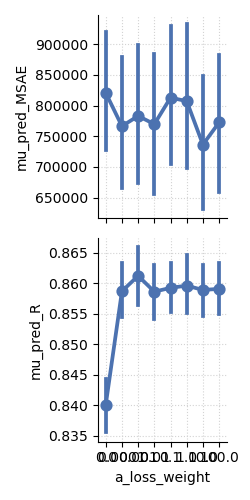

In [164]:
fig = ps.plot(
    m[m.spatial_region == 'all'],
    x=['a_loss_weight'],
    y=['mu_pred_MSAE', 'mu_pred_R'],
    height=2.5,
    width=2.5,
    legend=False,
    tight=True
)

In [168]:
m['method'] = 'PINN_' + m['pde_name']

direct_m = m[m.pde_name == 'hetero'].copy()
direct_m['method'] = 'direct_helmholtz'
for col in m.columns:
    if col.startswith('direct'):
        direct_m[col.replace('direct', 'mu')] = m[col]
        
hh_fem_m = m[m.pde_name == 'helmholtz'].copy()
hh_fem_m['method'] = 'FEM_helmholtz'
for col in m.columns:
    if col.startswith('fem'):
        hh_fem_m[col.replace('fem', 'mu')] = m[col]

ht_fem_m = m[m.pde_name == 'hetero'].copy()
ht_fem_m['method'] = 'FEM_hetero'
for col in m.columns:
    if col.startswith('fem'):
        ht_fem_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([direct_m, ht_fem_m, m])

method_order = ['direct_helmholtz', 'FEM_helmholtz', 'FEM_hetero', 'PINN_helmholtz', 'PINN_hetero']
mm['method_index'] = mm['method'].map(method_order.index)
mm = mm.sort_values('method_index')

In [169]:
import matplotlib as mpl
pct_format = mpl.ticker.PercentFormatter()

mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV'] * 100
mm['mu_pred_MAD_relative'] = mm['mu_pred_MAD'] / mm['mu_true_MAV'] * 100

In [170]:
%autoreload
import seaborn as sns
import matplotlib.pyplot as plt

colors = ps.results.get_color_palette(10, type='deep', min_val=0)
blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = colors

colors = [blue, yellow, red, cyan, green]
#colors = [blue, yellow, cyan]
sns.set_palette(colors)
colors = sns.color_palette()
colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

In [171]:
mm.spatial_region.unique()

array(['all', '1.0', '0.0'], dtype=object)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


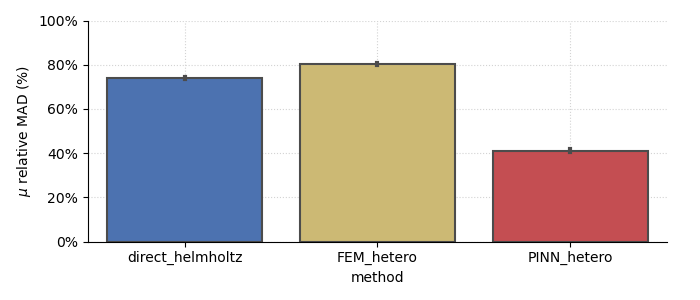

In [172]:
fig = ps.plot(
    mm[~mm.spatial_region.isin({'0.0', 'all'}) & ~mm.savgol_filter],
    x='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=7,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].set_ylim(0, 100)
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])   

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_method_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


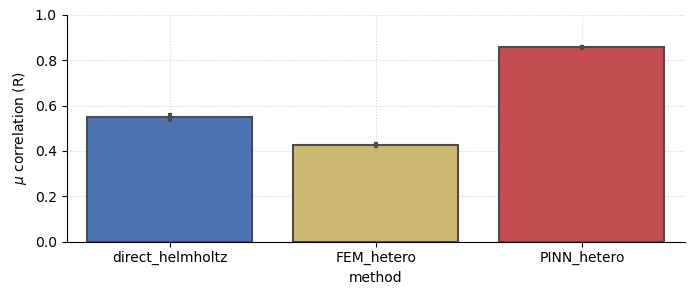

In [173]:
fig = ps.plot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all') & ~mm.savgol_filter].copy(), # across all omegas
    x='method',
    hue='method',
    y='mu_pred_R',
    height=3,
    width=7,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_ylim([0, 1])

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_method_R_bar_plot.{ext}', bbox_inches='tight', dpi=200)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


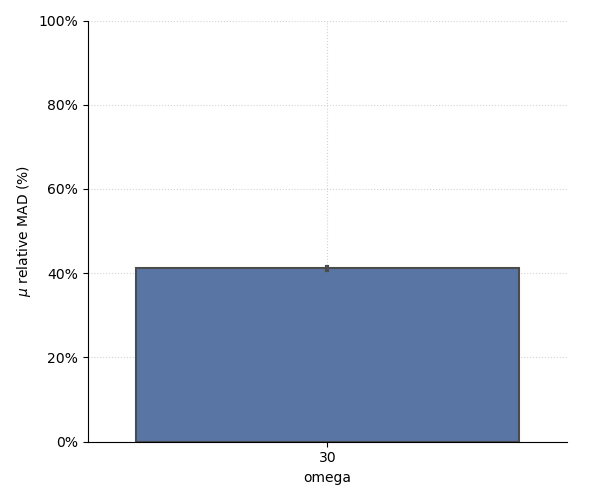

In [174]:
fig = ps.plot(
    mm[~mm.spatial_region.isin({'0', 'all'}) & mm.method.str.startswith('PINN')], 
    x='omega',
    y='mu_pred_MAD_relative',
    height=5,
    width=6,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 100)
fig.tight_layout()

fig.axes[0].set_xlabel('omega')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_omega_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [175]:
mm['a_loss_weight'][mm.a_loss_weight == 0] = 1e-6

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mm['a_loss_weight'][mm.a_loss_weight == 0] = 1e-6



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


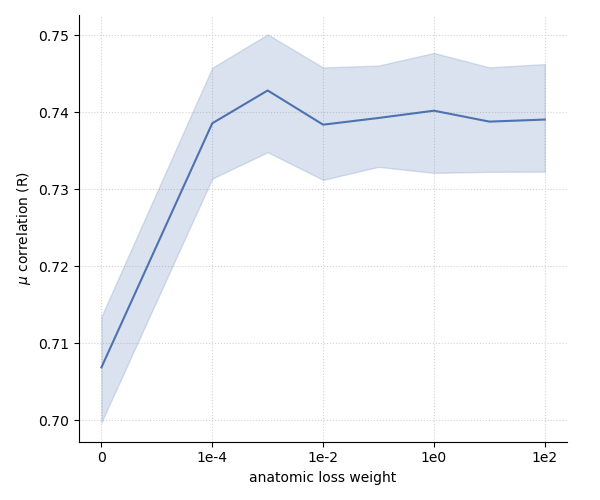

In [176]:
mm['mu_pred_R2'] = mm['mu_pred_R']**2

fig = ps.plot(
    mm[mm.spatial_region.isin({'all'}) & mm.method.str.startswith('PINN')], 
    x='a_loss_weight',
    y='mu_pred_R2',
    height=5,
    width=6,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_xlabel('anatomic loss weight')
fig.axes[0].set_xscale('log')
fig.axes[0].set_xticks([1e-6, 1e-4, 1e-2, 1e0, 1e2])
fig.axes[0].set_xticklabels(['0', '1e-4', '1e-2', '1e0', '1e2'])
fig.tight_layout()

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_anat_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


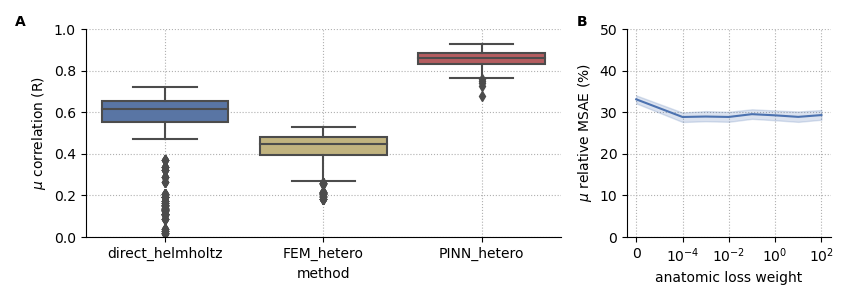

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3), width_ratios=(0.7, 0.3), squeeze=False)

sns.boxplot(
    mm[mm.spatial_region.isin({'all'}) & mm.savgol_filter & mm.a_loss_weight == 0],
    x='method',
    y='mu_pred_R',
    ax=ax[0,0]
)
ax[0,0].grid(linestyle=':')
ax[0,0].axes.set_axisbelow(True)
#ax[0,0].legend(frameon=True, fontsize='x-small', loc='lower left', ncol=3, edgecolor='w')

t = mpl.transforms.ScaledTranslation(-0.6, 0, fig.dpi_scale_trans)
ax[0,0].text(
    0, 1, 'A', fontweight='bold', va='bottom', ha='right',
    transform=ax[0,0].transAxes + t
)

ax[0,0].set_ylabel('$\mu$ correlation (R)')
ax[0,0].set_ylim(0, 1.0)
#ax[0,0].yaxis.set_major_formatter(pct_format)

ax[0,0].set_xlabel('method')
#ax[0,0].set_xticklabels(['background', 'target 1', 'target 2', 'target 3', 'target 4'])

sns.lineplot(
    mm[mm.spatial_region.isin({'all'}) & mm.method.str.startswith('PINN')],
    x='a_loss_weight',
    y='mu_pred_MSAE_relative',
    ax=ax[0,1]
)
ax[0,1].grid(linestyle=':')
ax[0,1].axes.set_axisbelow(True)

t = mpl.transforms.ScaledTranslation(-0.4, 0, fig.dpi_scale_trans)
ax[0,1].text(0, 1, 'B', fontweight='bold', va='bottom', ha='right', transform=ax[0,1].transAxes + t)

ax[0,1].set_ylabel('$\mu$ relative MSAE (%)')
ax[0,1].set_ylim(0, 50)
#ax[0,1].yaxis.set_major_formatter(pct_format)

ax[0,1].set_xlabel('anatomic loss weight')
ax[0,1].set_xscale('log')
ax[0,1].set_xticks([1e-6, 1e-4, 1e-2, 1e0, 1e2])
ax[0,1].set_xticklabels(['0'] + ax[0,1].get_xticklabels()[1:])

sns.despine(fig)
fig.tight_layout()

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_plots.{ext}', bbox_inches='tight', dpi=200)

In [180]:
%autoreload

blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = sns.color_palette('tab10')

mre_pinn.visual.COLORS.update(
    red=red,
    yellow=yellow,
    green=green,
    cyan=cyan,
    blue=blue
)

Loading ../data/NAFLD/v3/0006/wave.nc
Loading ../data/NAFLD/v3/0006/mre.nc
Loading ../data/NAFLD/v3/0006/mre_mask.nc
Loading ../data/NAFLD/v3/0006/anat.nc
Loading ../data/NAFLD/v3/0006/anat_mask.nc


<IPython.core.display.Javascript object>


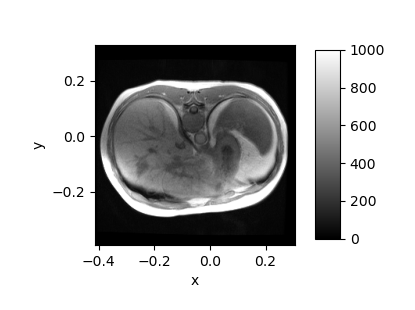

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



<IPython.core.display.Javascript object>


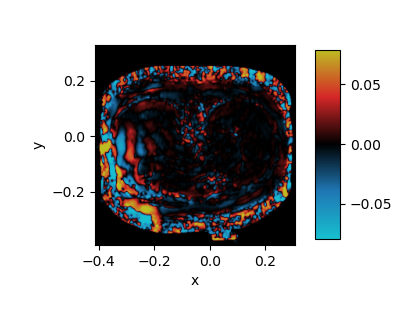

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



<IPython.core.display.Javascript object>


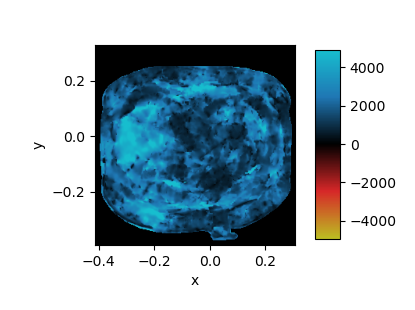

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



In [184]:
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v3', '0006', anat=True)
example.arrays['anat'] = example.anat.sel(z=0.018237183332, method='nearest')
example.view('anat', ax_height=2, space=0.2)
plt.gcf().tight_layout()
plt.savefig('images/patient_anat.png', dpi=200, bbox_inches='tight')
example.view('wave', ax_height=2, space=0.2)
plt.gcf().tight_layout()
plt.savefig('images/patient_wave.png', dpi=200, bbox_inches='tight')
example.view('mre', ax_height=2, space=0.2)
plt.gcf().tight_layout()
plt.savefig('images/patient_mre.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


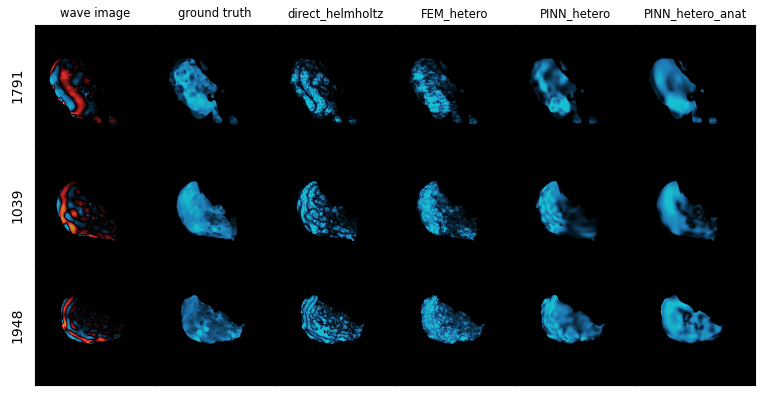

Loading ../data/NAFLD/v4/1791/wave.nc
Loading ../data/NAFLD/v4/1791/mre.nc
Loading ../data/NAFLD/v4/1791/mre_mask.nc
Loading 2023-2-26_patient_FEM/train_patient_1791_0_helmholtz/train_patient_1791_0_helmholtz_direct.nc
Loading 2023-2-26_patient_FEM/train_patient_1791_0_hetero/train_patient_1791_0_hetero_fem.nc
Loading 2023-2-18_patient_anat/train_patient_1791_30_hetero_0e+00/train_patient_1791_30_hetero_0e+00_elastogram.nc
Loading 2023-2-18_patient_anat/train_patient_1791_30_hetero_1e+00/train_patient_1791_30_hetero_1e+00_elastogram.nc
Loading ../data/NAFLD/v4/1039/wave.nc
Loading ../data/NAFLD/v4/1039/mre.nc
Loading ../data/NAFLD/v4/1039/mre_mask.nc
Loading 2023-2-26_patient_FEM/train_patient_1039_0_helmholtz/train_patient_1039_0_helmholtz_direct.nc
Loading 2023-2-26_patient_FEM/train_patient_1039_0_hetero/train_patient_1039_0_hetero_fem.nc
Loading 2023-2-18_patient_anat/train_patient_1039_30_hetero_0e+00/train_patient_1039_30_hetero_0e+00_elastogram.nc
Loading 2023-2-18_patient_anat/

In [231]:
%autoreload
import mre_pinn

image_names = [
    'wave image', 'ground truth', 'direct_helmholtz', 'FEM_hetero', 'PINN_hetero', 'PINN_hetero_anat'
]

pinn_expt_name = '2023-2-18_patient_anat'
pinn_job_name = 'train_patient_{example_id}_{omega}_{pde_name}_{a_loss_weight:.0e}'

fem_expt_name = '2023-2-26_patient_FEM'
fem_job_name = 'train_patient_{example_id}_{savgol_filter}_{pde_name}'

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1.2
    ax_height = ax_width
    
    omega = 30
    a_loss_weight = 1
    savgol_filter = 0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(
        n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25)
    )
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v4', example_id)
        z = example.mre.z[0]
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(example_id, fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = array.real * (example.mre_mask.values[...,0] > 0)

            elif image_name == 'ground truth':
                array = example.mre[...,0]
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array) * (example.mre_mask.values[...,0] > 0)

            elif image_name == 'direct_helmholtz':
                job_name = fem_job_name.format(
                    example_id=example_id, pde_name='helmholtz', savgol_filter=savgol_filter
                )
                nc_file = f'{fem_expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=z)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)
                
            elif image_name == 'FEM_helmholtz':
                job_name = fem_job_name.format(
                    example_id=example_id, pde_name='helmholtz', savgol_filter=savgol_filter
                )
                nc_file = f'{fem_expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=z)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_hetero':
                job_name = fem_job_name.format(
                    example_id=example_id, pde_name='hetero', savgol_filter=savgol_filter
                )
                nc_file = f'{fem_expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=z)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_helmholtz':
                job_name = pinn_job_name.format(
                    example_id=example_id, pde_name='helmholtz', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{pinn_expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=z)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_hetero':
                job_name = pinn_job_name.format(
                    example_id=example_id, pde_name='hetero', omega=omega, a_loss_weight=0
                )
                nc_file = f'{pinn_expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=z)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)
                
            elif image_name == 'PINN_hetero_anat':
                job_name = pinn_job_name.format(
                    example_id=example_id, pde_name='hetero', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{pinn_expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=z)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array[:-24,8:-16], **color_kws)
    
    return fig

#fig0 = plot_image_grid(['0006', '0020', '0024', '0029'])
#fig1 = plot_image_grid(['0043', '0047', '0126', '0135'])
#fig = plot_image_grid(['2029', '1948', '1940', '1839', '1791', '1671', '1448', '1435', '1045', '1039'])
fig = plot_image_grid(['1791', '1039', '1948'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_image_grid.{ext}', bbox_inches='tight', dpi=200)
    pass

In [ ]:
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v3', '0006')
example.view()

In [ ]:
import xarray as xr
u = example.wave
x = u.field.points(reshape=False)
x = (x - x.mean(axis=(0,1,2), keepdims=True)) / (x.max(axis=(0,1,2), keepdims=True) - x.min(axis=(0,1,2), keepdims=True))
x, y, z = x[...,0], x[...,1], x[...,2]
r = np.sqrt(x**2 + y**2)
sin = y / (r + 1e-3)
cos = x / (r + 1e-3)
x = np.stack([x, y, z, r, sin, cos], axis=-1)

print(x.shape)
x_dims = ['x', 'y', 'z', 'component']
x_coords = {
    'x': u.x,
    'y': u.y,
    'z': u.z,
    'component': ['x', 'y', 'z', 'r', 'sin', 'cos']
}
x = xr.DataArray(x, coords=x_coords, dims=x_dims)
x.name = 'position'
mre_pinn.visual.XArrayViewer(x, ax_height=3)

In [ ]:
example.wave.coords